## Loading Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

## Stopwords, stemming, and tokenizing

In [452]:
import os
data_folder = os.path.join('C:/Users/Buttonwood/Desktop/Work Model', 'speeches')

file_list = [os.path.join(data_folder, fname)
                    for fname in os.listdir(data_folder)]


speeches = []
speechnames=[]
for filen in file_list:
    filename = os.path.basename(filen)
    topic= os.path.splitext(filename)[0]
    speechnames.append(topic)
    with open(filen) as handle:
        speeches.append(handle.read())
print(str(len(speeches)) + ' speeches')
print(str(len(speechnames)) + ' titles')

74 speeches
74 titles


In [3]:
speeches[0][:200]

'Mr. Speaker, Mr. Vice President, Members of Congress, fellow citizens: Fifty-one years ago, John F. Kennedy declared to this Chamber that "the Constitution makes us not rivals for power but partners f'

In [4]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(speechnames)):
    ranks.append(i)

In [5]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [150]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    text=text.lower()
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    text=text.lower()
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [151]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in speeches:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [153]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [155]:
vocab_frame.head(10)

,words
mr.,mr.
speaker,speaker
mr.,mr.
vice,vice
presid,president
member,members
of,of
congress,congress
fellow,fellow
citizen,citizens


## Tf-idf and document similarity

In [405]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(speeches)

print(tfidf_matrix.shape)

Wall time: 11.5 s
(74, 1554)


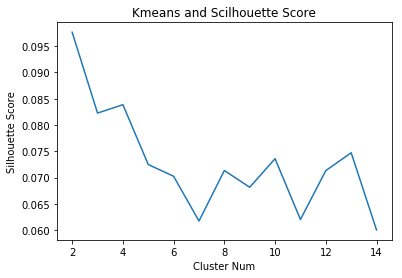

In [423]:
'''Determine Number of K in Kmeans Algorithm'''
from sklearn.metrics import silhouette_score
silScore=[]
for i in range(2,15):
    km = KMeans(n_clusters=i)
    km.fit(tfidf_matrix)
    pred_Value=km.predict(tfidf_matrix)
    silScore.append(silhouette_score(tfidf_matrix,pred_Value))
    
plt.plot(range(2,15),silScore)
plt.title("Kmeans and Scilhouette Score")
plt.xlabel("Cluster Num")
plt.ylabel("Silhouette Score")

###  Silhouette score tells us that the best cluster size is 3

In [11]:
terms = tfidf_vectorizer.get_feature_names()

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## K-means clustering

In [411]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
len(clusters)

Wall time: 739 ms


74

In [15]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [412]:
import pandas as pd

speech_ = { 'title': speechnames, 'rank': ranks, 'speech': speeches, 'cluster': clusters}
frame = pd.DataFrame(speech_, index = [clusters] , columns = ['rank', 'title', 'cluster', 'speech'])

In [413]:
frame.head(n=10)

,rank,title,cluster,speech
2,0,"Barack_Obama_February_12,_2013",2,"Mr. Speaker, Mr. Vice President, Members of Co..."
2,1,"Barack_Obama_February_24,_2009",2,"Madame Speaker, Mr. Vice President, Members of..."
2,2,"Barack_Obama_January_12,_2016",2,"Mr. Speaker, Mr. Vice President, Members of Co..."
2,3,"Barack_Obama_January_20,_2015",2,"The President. Mr. Speaker, Mr. Vice President..."
2,4,"Barack_Obama_January_24,_2012",2,"Mr. Speaker, Mr. Vice President, members of Co..."
2,5,"Barack_Obama_January_25,_2011",2,"Mr. Speaker, Mr. Vice President, members of Co..."
2,6,"Barack_Obama_January_27,_2010",2,"Madame Speaker, Vice President Biden, Members ..."
2,7,"Barack_Obama_January_28,_2014",2,"Mr. Speaker, Mr. Vice President, Members of Co..."
1,8,"Dwight_D._Eisenhower_February_2,_1953",1,"Mr. President, Mr. Speaker, Members of the Eig..."
1,9,"Dwight_D._Eisenhower_January_10,_1957",1,To the Congress of the United States: I appear...


In [414]:
frame['cluster'].value_counts()

1    38
2    28
0     8
Name: cluster, dtype: int64

In [415]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    25.375000
1    36.421053
2    39.785714
Name: rank, dtype: float64

In [417]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % vocab_frame.loc[terms[ind].split()].values.tolist()[0][0], end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: terrorists, iraq, terrorism, tonight, enemies, regime, afghanistan, reforms, september, passed, attacked, women, drug, leads, intelligence, killed, accountants, thanks, troops, men,

Cluster 0 titles: George_W._Bush_February_2,_2005, George_W._Bush_January_20,_2004, George_W._Bush_January_23,_2007, George_W._Bush_January_28,_2003, George_W._Bush_January_28,_2008, George_W._Bush_January_29,_2002, George_W._Bush_January_31,_2006, George_W._Bush_September_20,_2001,

Cluster 1 words: shall, recommendations, prices, soviets, communist, administration, area, presents, farms, cooperation, expenditures, industries, local, inflation, labor, free, maintain, fiscal, vietnam, authors,

Cluster 1 titles: Dwight_D._Eisenhower_February_2,_1953, Dwight_D._Eisenhower_January_10,_1957, Dwight_D._Eisenhower_January_12,_1961, Dwight_D._Eisenhower_January_5,_1956, Dwight_D._Eisenhower_January_6,_1955, Dwight_D._Eisenhower_January_7,_1954, Dwight_D._Eisenhower_Januar

## Multidimensional scaling

In [418]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

## Visualizing document clusters

In [420]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
cluster_names = {0: 'Terrorists, Afghanistan, Enemies',
                 1: 'America, Inflation, Deficit, Labor, Fiscal Expenditure', 
                 2: 'Parents, Children, Health, Education'}

In [421]:
%matplotlib inline

C:\Users\Buttonwood\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


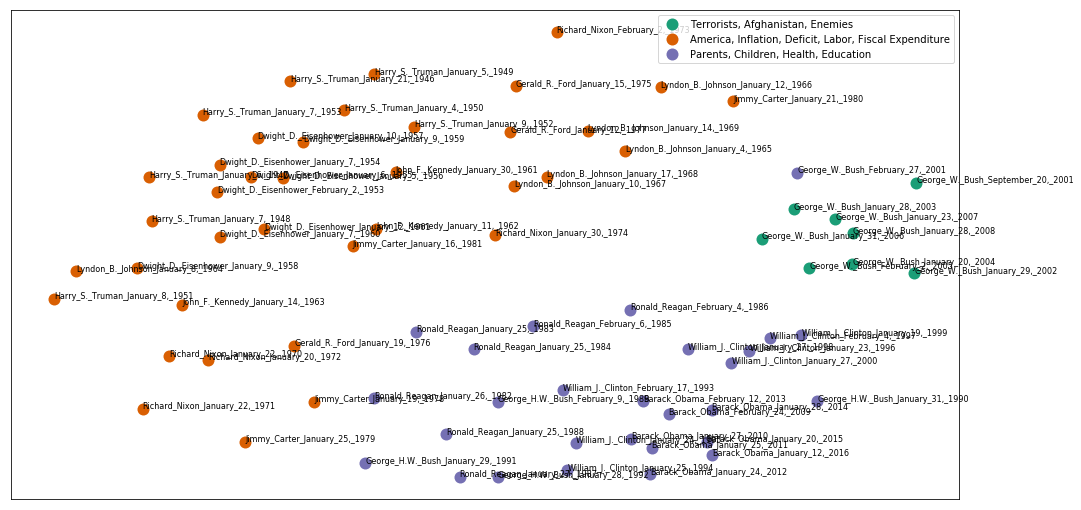

In [422]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=speechnames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [31]:
plt.close()

In [424]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [425]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=speechnames)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

## LDA Modeling for Topic

### LDA Modeling for 5 Topic, Since The Area of Each Circle Is Almost Identical 

In [131]:
'''Text Preprocessing'''
from nltk.tokenize import word_tokenize, sent_tokenize
from string import punctuation
from nltk.corpus import stopwords
def tokenizer(text):
    try:
        stop = set(stopwords.words('english'))
        
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for word in tokens_:
            tokens += word
  
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', # Remove any dash and ellipse
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        
        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    except:
        print('data can not be tokenized')

In [170]:
def tokenizer_noStem(text):
    try:
        stop = set(stopwords.words('english'))
        
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for word in tokens_:
            tokens += word
  
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', # Remove any dash and ellipse
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        
        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
        return filtered_tokens
    except:
        print('data can not be tokenized')

In [442]:
frame['tokens'] = frame['speech'].map(tokenizer)

In [443]:
frame.head(5)

,rank,title,cluster,speech,POS_nouns,tokens_nouns,tokens
2,0,"Barack_Obama_February_12,_2013",2,"Mr. Speaker, Mr. Vice President, Members of Co...","Mr. Speaker, Mr. Vice President, Members Congr...","[mr., speaker, mr., vice, presid, member, cong...","[mr., speaker, mr., vice, presid, member, cong..."
2,1,"Barack_Obama_February_24,_2009",2,"Madame Speaker, Mr. Vice President, Members of...","Madame Speaker, Mr. Vice President, Members Co...","[madam, speaker, mr., vice, presid, member, co...","[madam, speaker, mr., vice, presid, member, co..."
2,2,"Barack_Obama_January_12,_2016",2,"Mr. Speaker, Mr. Vice President, Members of Co...","Mr. Speaker, Mr. Vice President, Members Congr...","[mr., speaker, mr., vice, presid, member, cong...","[mr., speaker, mr., vice, presid, member, cong..."
2,3,"Barack_Obama_January_20,_2015",2,"The President. Mr. Speaker, Mr. Vice President...","President. Mr. Speaker, Mr. Vice President, Me...","[presid, mr., speaker, mr., vice, presid, memb...","[presid, mr., speaker, mr., vice, presid, memb..."
2,4,"Barack_Obama_January_24,_2012",2,"Mr. Speaker, Mr. Vice President, members of Co...","Mr. Speaker, Mr. Vice President, members Congr...","[mr., speaker, mr., vice, presid, member, cong...","[mr., speaker, mr., vice, presid, member, cong..."


In [444]:
'''Show Top 10 tokens in each speeches'''
from collections import Counter

def topTokens(title):
    tokens = frame[frame['title'] == title]['tokens']
    allTokens = []
    for token in tokens:
        allTokens+=token
    counter = Counter(allTokens)
    return counter.most_common(10)


for title in set(frame['title']):
    print('title :', title)
    print('top 10 keywords:', topTokens(title))
    print('---')

title : Ronald_Reagan_January_25,_1984
top 10 keywords: [('america', 31), ('peopl', 28), ('peac', 26), ('us', 23), ('year', 20), ('must', 20), ('help', 20), ('govern', 19), ('tax', 19), ('could', 18)]
---
title : William_J._Clinton_January_27,_1998
top 10 keywords: [('year', 59), ('america', 45), ('new', 45), ('american', 37), ('nation', 33), ('must', 30), ('everi', 29), ('help', 26), ('congress', 25), ('work', 25)]
---
title : Harry_S._Truman_January_21,_1946
top 10 keywords: [('year', 227), ('dollar', 210), ('war', 196), ('govern', 149), ('million', 145), ('nation', 135), ('program', 132), ('fiscal', 129), ('expenditur', 128), ('state', 97)]
---
title : Lyndon_B._Johnson_January_12,_1966
top 10 keywords: [('year', 33), ('vietnam', 32), ('peopl', 32), ('nation', 30), ('tonight', 25), ('must', 23), ('help', 19), ('peac', 19), ('american', 18), ('make', 18)]
---
title : Ronald_Reagan_January_26,_1982
top 10 keywords: [('program', 42), ('govern', 33), ('american', 26), ('year', 25), ('ta

In [445]:
'''Modeling'''
import lda
from sklearn.feature_extraction.text import CountVectorizer

In [446]:
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [447]:
cvectorizer = CountVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, tokenizer=tokenizer_noStem, ngram_range=(1,3))
cvz=cvectorizer.fit_transform(frame['speech'])

n_topics = 5
n_iter = 100
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz) 


In [448]:
n_top_words = 20
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: community challenge let us propose ask last year years ago crime create think fight look weapons mr. move enough open find chance training
Topic 1: shall local inflation federal government among income essential individual problem additional certain domestic develop commission message food sound governments justice armed
Topic 2: tonight 've 're get reform health care child cut century change said 'll deficit spending young businesses pay women pass bill
Topic 3: administration soviet countries major assistance problems nuclear political including four vital areas increased order threat allies remain continued interests international
Topic 4: dollars fiscal production control expenditures present toward fiscal year upon necessary labor prices price international needed purpose services employment aid united nations


In [449]:
'''Visualize Topic Modeling'''
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list( frame['tokens'].map(len)),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

ldadata = prepareLDAData()

In [205]:
import pyLDAvis

In [207]:
pyLDAvis.enable_notebook()

In [209]:
prepared_data = pyLDAvis.prepare(**ldadata)

C:\Users\Buttonwood\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


In [211]:
pyLDAvis.save_html(prepared_data,'./pyldadavis.html')

## LDA Only Including NNS NN NNP NNPS

In [451]:
### Extract only NNS NN NNP NNPS
from nltk.tag import pos_tag

def POS_nouns(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    nouns = [word for word,pos in tagged if pos in ['NN','NNS','NNP','NNPS']]
    return (" ".join(nouns))


# Same Shit
def strip_POS(text): 
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    output=[]
    for pos in tagged:
        if pos[1] in ['NN','NNS','NNP','NNPS']:
            output.append(pos[0])
    return output

In [431]:
frame['POS_nouns']=frame['speech'].map(POS_nouns)

In [432]:
frame.head()

,rank,title,cluster,speech,POS_nouns
2,0,"Barack_Obama_February_12,_2013",2,"Mr. Speaker, Mr. Vice President, Members of Co...","Mr. Speaker, Mr. Vice President, Members Congr..."
2,1,"Barack_Obama_February_24,_2009",2,"Madame Speaker, Mr. Vice President, Members of...","Madame Speaker, Mr. Vice President, Members Co..."
2,2,"Barack_Obama_January_12,_2016",2,"Mr. Speaker, Mr. Vice President, Members of Co...","Mr. Speaker, Mr. Vice President, Members Congr..."
2,3,"Barack_Obama_January_20,_2015",2,"The President. Mr. Speaker, Mr. Vice President...","President. Mr. Speaker, Mr. Vice President, Me..."
2,4,"Barack_Obama_January_24,_2012",2,"Mr. Speaker, Mr. Vice President, members of Co...","Mr. Speaker, Mr. Vice President, members Congr..."


In [433]:
'''Modeling'''
import lda
from sklearn.feature_extraction.text import CountVectorizer

In [434]:
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [435]:
frame['tokens_nouns'] = frame['POS_nouns'].map(tokenizer)

In [436]:
frame.head()

,rank,title,cluster,speech,POS_nouns,tokens_nouns
2,0,"Barack_Obama_February_12,_2013",2,"Mr. Speaker, Mr. Vice President, Members of Co...","Mr. Speaker, Mr. Vice President, Members Congr...","[mr., speaker, mr., vice, presid, member, cong..."
2,1,"Barack_Obama_February_24,_2009",2,"Madame Speaker, Mr. Vice President, Members of...","Madame Speaker, Mr. Vice President, Members Co...","[madam, speaker, mr., vice, presid, member, co..."
2,2,"Barack_Obama_January_12,_2016",2,"Mr. Speaker, Mr. Vice President, Members of Co...","Mr. Speaker, Mr. Vice President, Members Congr...","[mr., speaker, mr., vice, presid, member, cong..."
2,3,"Barack_Obama_January_20,_2015",2,"The President. Mr. Speaker, Mr. Vice President...","President. Mr. Speaker, Mr. Vice President, Me...","[presid, mr., speaker, mr., vice, presid, memb..."
2,4,"Barack_Obama_January_24,_2012",2,"Mr. Speaker, Mr. Vice President, members of Co...","Mr. Speaker, Mr. Vice President, members Congr...","[mr., speaker, mr., vice, presid, member, cong..."


In [437]:
cvectorizer = CountVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, tokenizer=tokenizer_noStem, ngram_range=(1,3))
cvz=cvectorizer.fit_transform(frame['POS_nouns'])

n_topics = 5
n_iter = 100
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz) 


In [438]:
n_top_words = 15
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: administration dollars legislation act production problems housing areas needs expenditures assistance cooperation labor control increase
Topic 1: energy weapons women goal allies place agreement force threat times man technology oil iraq countries
Topic 2: tonight 've plan let century schools 're community reform health care deficit spending school workers taxes


In [439]:
'''Visuals for only Nouns'''
'''Visualize Topic Modeling'''
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list( frame['tokens_nouns'].map(len)),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

ldadata = prepareLDAData()

In [440]:
import pyLDAvis

In [441]:
pyLDAvis.enable_notebook()

In [400]:
prepared_data = pyLDAvis.prepare(**ldadata)

C:\Users\Buttonwood\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


In [402]:
pyLDAvis.save_html(prepared_data,'./pyldanouns.html')

In [403]:
frame.to_pickle('frame.pkl')